## Golden wind in r/WallStreetBets

* Modeling & Prediction of r/WallStreetBets Research Project Phase 3
* Team 4
* Jiashuo Sun, Anqi Fang, Raymond Su
* Research Questions attempted in this notebook:
1.   Characteristics of popular submissions
2.   Predict what kind of submission will get popular on subreddit r/WallStreetBets?

**This is a note book for part 6 and 7 of our analysis - Characteristics of popular submissions and Prediction. We will be using word cloud and interactive visualization to show the result.**

In [ ]:
# !pip install vaderSentiment

In [ ]:
#Import library that that needed for modeling and analysis
import pandas as pd
import numpy as np
from datetime import datetime
from numpy.random import seed
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import nltk, re, json, io
from nltk.tokenize import word_tokenize,RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import xgboost as xgb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Analysis from Post/Submission Perspectives

---

* At the beginning of this project, our final goal is to find out a way to predict social media event like GameStop in 2021. This question is very broad and hard, so we think it might be a good idea to begin from predicting popular submission as the first step. If we are able to predict whether a post will become popular, then we might be able to monitor the popular submissions in a certain period of time. If some topics or discussions happen quite frequently in the predicted popular submissions and the frequency exceeds certain threshold, this might be the signal for a major event or hot topic emerging.
* To predict which submissions are going to get popular, the first step is to analyze the main characteristics of the popular submissions, and then we will try to predict whether a new submission will get popular or not. 

In [ ]:
df = pd.read_csv("./drive/MyDrive/Colab Notebooks/cleaned_submissions.csv")

In [ ]:
df.shape

(66457, 13)

In [ ]:
df.isnull().sum()

author             0
created_utc        0
id                 0
num_comments       0
score              0
selftext           0
title              0
upvote_ratio       0
created            0
timestamp          0
date               0
cleaned_text    1275
tokened_text       0
dtype: int64

In [ ]:
df = df[df.cleaned_text.notnull()]

### Define "Popular"

* We want to define what is considered as "popular". There are two requirements: upvote ratio and number of total votes (score). We want the upvote ratio to be high, and at the same time, we want the number of total votes to be high as well. With these two requirements satisfied, we can exclude those with very few number of votes but a high upvote ratio (e.g. those with only 1 or 2 votes but all votes are upvotes).
* From the distribution of scores below, we can find that majority of the submissions have scores under 50. So let's set the threshold to be 50 for now, and modify it in the future if necessary.
* Since the proportion of submissions with scores over 50 is very low, we want to keep as much these submissions as possible, otherwise the labels would be more imbalanced. From the distribution of upvote ratios for submissions with over 50 scores, we can find that majority of the ratios is over 0.8, so let's set the upvote ratio threshold to be 0.8.

In [ ]:
scores = df.score
# comments  = df.num_comments

Text(0.5, 0, 'Score')

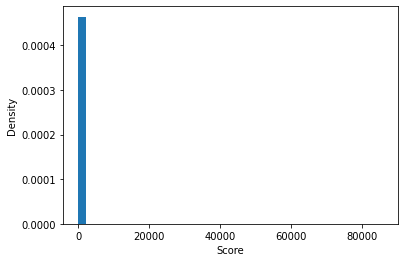

In [ ]:
%matplotlib inline

# the full range is too large that we cannot clearly see how the small scores are distributed
plt.hist(scores, density=True, bins=40)
plt.ylabel('Density')
plt.xlabel('Score')

Text(0.5, 0, 'Score')

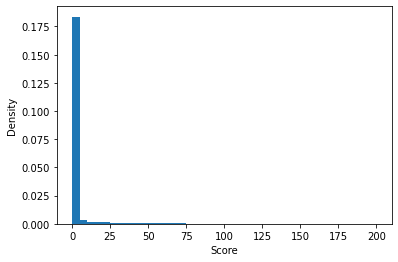

In [ ]:
# We shortened the range to (0, 200)
plt.hist(scores, density=True, bins=40, range = (0,  200))
plt.ylabel('Density')
plt.xlabel('Score')

In [ ]:
# let's set the threshold to be 50, and check the number of posts with scores over 50
df[df.score >= 50].shape

(2740, 13)

In [ ]:
# the ratio of posts with scores over 50
df[df.score >= 50].shape[0] / df.shape[0]

0.04203614494799178

In [ ]:
ratios = df[df.score >= 50].upvote_ratio

Text(0.5, 0, 'Ratios')

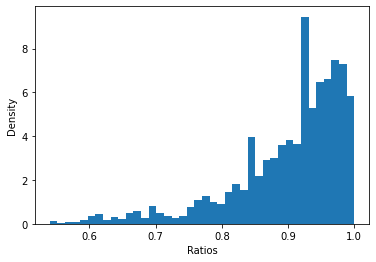

In [ ]:
plt.hist(ratios, density=True, bins=40)  # density=False would make counts
plt.ylabel('Density')
plt.xlabel('Ratios')

In [ ]:
df['pop_or_not'] = np.where((df['score'] >= 50) & (df.upvote_ratio >= 0.8), 1, 0)

In [ ]:
df[df.pop_or_not == 1].shape

(2434, 14)

In [ ]:
df[df.pop_or_not == 0].shape

(62748, 14)

## Part 6: Characteristics of the popular submissions

---

* Firstly, we will compare the most frequent tokens of popular submissions and unpopular submissions. The most frequent tokens will be calculated by two methods:
  *   Term Frequency: counting the number of occurence
  *   TF-IDF: the raw term frequency, times the inverse document frequency
* Secondly, I will calculate the sentiment score and subjectivity score of the popular submissions and unpopular submissions, and compare the two sets of submissions



#### Frequent tokens by Term Frequency

In [ ]:
df.head(1)

,author,created_utc,id,num_comments,score,selftext,title,upvote_ratio,created,timestamp,date,cleaned_text,tokened_text,pop_or_not
0,Zckary,1607414431,k90ai4,3,1,19 year old college student in debt looking fo...,SERIOUS INQUIRIES ONLY,1.0,1.607440e+09,2020-12-08 15:00:31,2020-12-08,year old college student debt looking way will...,"['year', 'old', 'college', 'student', 'debt', ...",0


In [ ]:
# convert the dataframe column to list
pop_txt = df[df.pop_or_not == 1].cleaned_text.to_list()
unpop_txt = df[df.pop_or_not == 0].cleaned_text.to_list()

In [ ]:
doc_list = [" ".join(pop_txt), " ".join(unpop_txt)]

In [ ]:
# calculate term frequency by CountVectorizer
# first instantiate CountVectorizer object and the also removing stopwords here
cv = CountVectorizer(stop_words='english') 
data_cv = cv.fit_transform(doc_list)
data_array = data_cv.toarray()
data_array.shape

(2, 136529)

In [ ]:
all_features = cv.get_feature_names_out()

In [ ]:
len(all_features)

136529

In [ ]:
cnt_vec = pd.DataFrame()
cnt_vec['tokens'] = all_features
cnt_vec['pop_cnt'] = data_array[0,:] #all countVectorizer features for popular submissions
cnt_vec['unpop_cnt'] = data_array[1, :] #all countVectorizer features for unpopular submissions

cnt_vec.head()

,tokens,pop_cnt,unpop_cnt
0,aa,3,29
1,aaa,1,10
2,aaaa,0,1
3,aaaaa,0,1
4,aaaaaa,0,1


In [ ]:
pop_top50 = cnt_vec.sort_values(by=['pop_cnt'], ascending=False).head(50)
unpop_top50 = cnt_vec.sort_values(by=['unpop_cnt'], ascending=False).head(50)

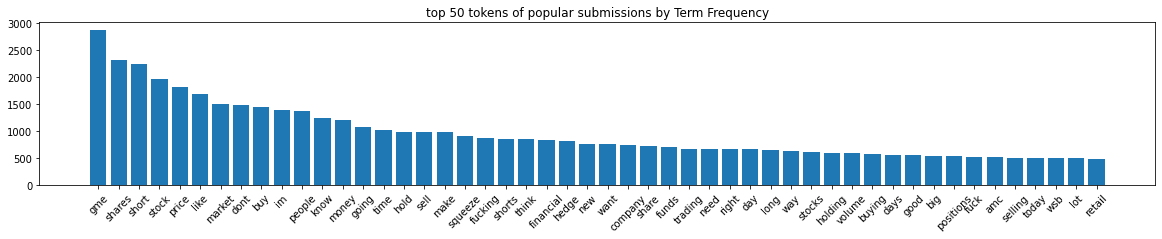

In [ ]:
plt.figure(figsize=(20,3))
plt.bar(pop_top50.tokens, pop_top50.pop_cnt, data = pop_top50)
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.title("top 50 tokens of popular submissions by Term Frequency")
plt.show()

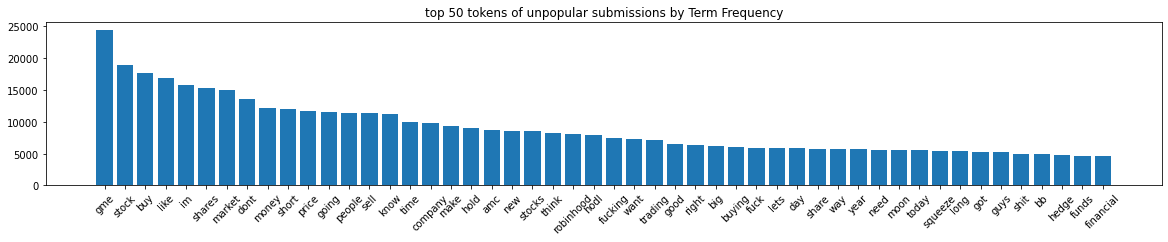

In [ ]:
plt.figure(figsize=(20,3))
plt.bar(unpop_top50.tokens, unpop_top50.unpop_cnt, data = unpop_top50)
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.title("top 50 tokens of unpopular submissions by Term Frequency")
plt.show()

* For popular submissions, there are more informative tokens and all tokens are proper languages. 

* While for unpopular submissions, there are less informative tokens and some of the most frequently seen tokens are taboo words like "shit", "fuck", etc and meaningless words like "think", "want", etc.





#### Frequent tokens by TF-IDF

In [ ]:
# calculate TF-IDF by TfidfVectorizer
# first instantiate TfidfVectorizer object and the also removing stopwords here
tfidf = TfidfVectorizer(stop_words='english') 
data_tfidf = tfidf.fit_transform(doc_list)
data_array2 = data_tfidf.toarray()
data_array2.shape

(2, 136529)

In [ ]:
all_features = tfidf.get_feature_names_out()

In [ ]:
tfidf_vec = pd.DataFrame()
tfidf_vec['tokens'] = all_features
tfidf_vec['pop_tfidf'] = data_array2[0,:] #all tf-idf features for popular submissions
tfidf_vec['unpop_tfidf'] = data_array2[1, :] #all tf-idf features for unpopular submissions

tfidf_vec.head()

,tokens,pop_tfidf,unpop_tfidf
0,aa,0.000326,0.000346
1,aaa,0.000109,0.000119
2,aaaa,0.000000,0.000017
3,aaaaa,0.000000,0.000017
4,aaaaaa,0.000000,0.000017


In [ ]:
pop_top50 = tfidf_vec.sort_values(by=['pop_tfidf'], ascending=False).head(50)
unpop_top50 = tfidf_vec.sort_values(by=['unpop_tfidf'], ascending=False).head(50)

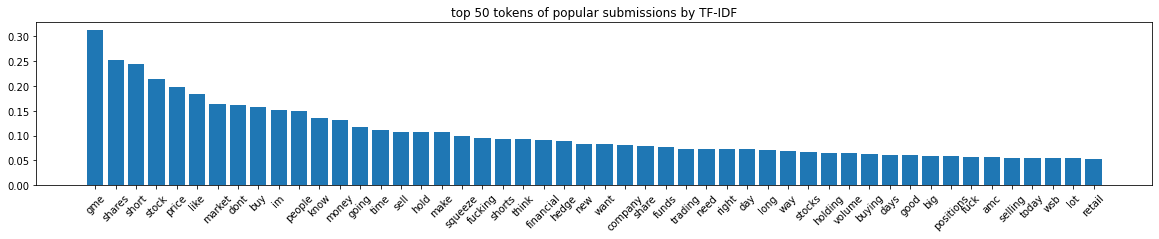

In [ ]:
plt.figure(figsize=(20,3))
plt.bar(pop_top50.tokens, pop_top50.pop_tfidf, data = pop_top50)
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.title("top 50 tokens of popular submissions by TF-IDF")
plt.show()

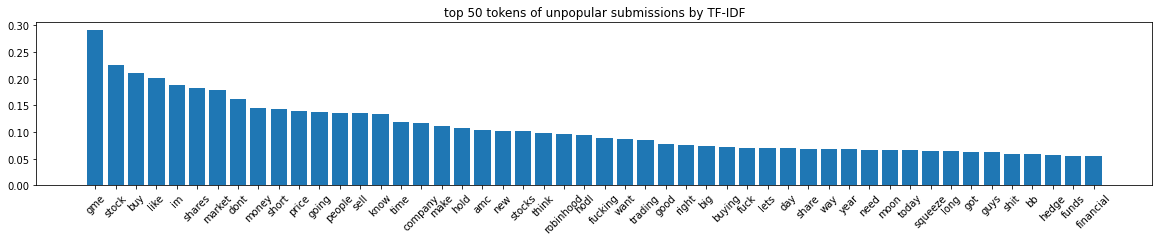

In [ ]:
plt.figure(figsize=(20,3))
plt.bar(unpop_top50.tokens, unpop_top50.unpop_tfidf, data = unpop_top50)
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.title("top 50 tokens of unpopular submissions by TF-IDF")
plt.show()

* There are not too much differences in the lists of most frequent tokens found by raw term frequency and TF-IDF. Same observation holds here.

#### Sentiment and Subjectivity Scores

In [ ]:
textblob_sen_pop = []
textblob_sub_pop = []

for item in pop_txt:
    blob = TextBlob(item)
    textblob_sen_pop.append(blob.polarity)
    textblob_sub_pop.append(blob.subjectivity)

In [ ]:
textblob_sen_unpop = []
textblob_sub_unpop = []

for item in unpop_txt:
    blob = TextBlob(item)
    textblob_sen_unpop.append(blob.polarity)
    textblob_sub_unpop.append(blob.subjectivity)

The sentiment score comparison:

* Both popular and unpopular sentiment scores are approximately normally distributed
* In general, popular submissions carry stronger sentiment than unpopular submissions, because most of the unpopular submissions are centered at 0 score, while popular submissions distribute more sparsely around [-0.25, 0.25]
* This observation aligns with our pre-assumption, submissions carrying stronger sentiment have higher chance to become popular because they are appealing to users.

Text(0.5, 0, 'Popular Submission Sentiment Score')

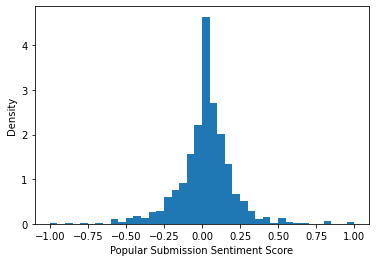

In [ ]:
plt.hist(textblob_sen_pop, density=True, bins=40)  # density=False would make counts
plt.ylabel('Density')
plt.xlabel('Popular Submission Sentiment Score')

Text(0.5, 0, 'Unpopular Submission Sentiment Score')

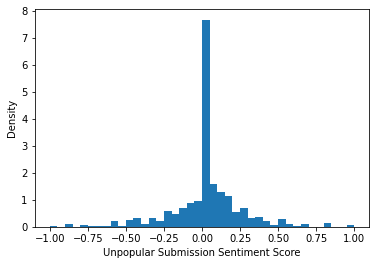

In [ ]:
plt.hist(textblob_sen_unpop, density=True, bins=40)  # density=False would make counts
plt.ylabel('Density')
plt.xlabel('Unpopular Submission Sentiment Score')

The subjectivity score comparison:

*  Both distributions are interestingly bimodal, with a large proportion being very objective (0 subjectivity score), and the remaining being normally distributed.
* Moreover, popular submissions are more subjective than unpopular submissions,  which is consistent with the sentiment score observation because in general content carrying stronger sentiment might be considered as more subjective, while content carrying weaker sentiment might be considered more objective.

Text(0.5, 0, 'Popular Submission Subjectivity Score')

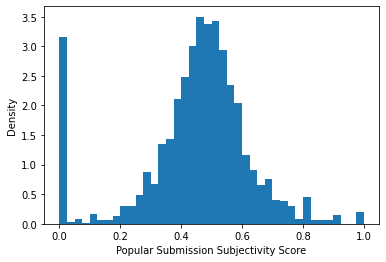

In [ ]:
plt.hist(textblob_sub_pop, density=True, bins=40)  # density=False would make counts
plt.ylabel('Density')
plt.xlabel('Popular Submission Subjectivity Score')

Text(0.5, 0, 'Unpopular Submission Subjectivity Score')

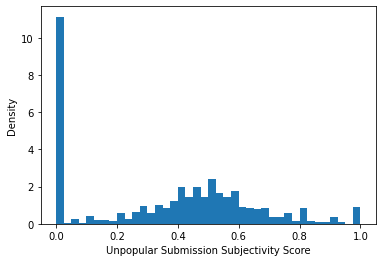

In [ ]:
plt.hist(textblob_sub_unpop, density=True, bins=40)  # density=False would make counts
plt.ylabel('Density')
plt.xlabel('Unpopular Submission Subjectivity Score')

**In conclusion, contents of popular submissions carry stronger sentiment and the tones are more subjective. Furthermore, popular submissions use more informative words and less taboo words than unpopular submissions, which might be related to the reccomendation mechanism of the Reddit forum.**




## Part 7: Predict what kind of submission will get popular on subreddit r/WallStreetBets?
---

* We are going to use the TF-IDF matrix plus sentiment and subjectivity scores as the input to classification models.
* We are going to try logistic regression, random forest classifier and XGBoost classifier. Logistic regression serves as a reference line for the classification. random forest classifier and XGBoost classifier can provide us with feature importance rankings, so that we can know which features are most important in predicting the popularity of the submission. 
* Since this dataset is an extremely imbalanced dataset, with 4% class 1 and 96% class 0, we need to downsample the majority class to around 15000, then calculate the TF-IDF matrix, along with sentiment and subjectivity scores, then use SMOTE to synthesize new data points for the minority class, in order to upsample the minority class with new information. The desired ratio of majority class versus minority class is 2:1
* Moreover, since we mostly care about whether we can predict the popular submission correctly, F1 score is a better evaluation metrics than the simple accuracy score.

In [ ]:
df.shape

(65182, 14)

In [ ]:
df['pop_or_not'].value_counts()

0    62748
1     2434
Name: pop_or_not, dtype: int64

**Downsampling the majority class**

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

In [ ]:
#create two different dataframe of majority and minority class 
df_majority = df[(df['pop_or_not']==0)] 
df_minority = df[(df['pop_or_not']==1)] 
# downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples= 15000,
                                 random_state=42)  # reproducible results
# Combine majority class with upsampled minority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

In [ ]:
df_downsampled['pop_or_not'].value_counts()

0    15000
1     2434
Name: pop_or_not, dtype: int64

**After downsampling the majority class, we need to tranform the data into TF-IDF matrix**

In [ ]:
all_text = df_downsampled.cleaned_text.to_list()
### use CountVectorizer and remove stopwords, remove too frequent tokens and remove very rare tokens
contents_bow = CountVectorizer(stop_words='english', max_df = 0.1, min_df = 30).fit(all_text)
contents = contents_bow.transform(all_text)
### tranform to TF-IDF matrix
transform_tfidf = TfidfTransformer().fit(contents)
contents_tfidf = transform_tfidf.transform(contents)
features_full = pd.DataFrame(contents_tfidf.toarray(), columns=contents_bow.get_feature_names_out())

features_full.shape

(17434, 3145)

In [ ]:
textblob_sen = []
textblob_sub = []

for item in all_text:
    blob = TextBlob(item)
    textblob_sen.append(blob.polarity)
    textblob_sub.append(blob.subjectivity)

In [ ]:
features_full['sentiment'] = textblob_sen
features_full['subjectivity'] = textblob_sub
labels = df_downsampled['pop_or_not']

**SMOTE to upsample the minority class**

In [ ]:
### use the SMOTE method to upsampling the minority class
over = SMOTE(sampling_strategy=0.5)
X, y = over.fit_resample(features_full, labels)

In [ ]:
y.value_counts()

0    15000
1     7500
Name: pop_or_not, dtype: int64

**After achieving the 2:1 ideal label ratio, now we can standardize the features, and then split train test dataset.**

In [ ]:
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 42, stratify = y)

### Logistic Regression

In [ ]:
### according to the documentation, "saga" will make it converge faster for large datasets
lr_model = LogisticRegression(solver = 'saga')
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [ ]:
confusion_matrix(y_test, y_pred)

array([[2319,  681],
       [ 368, 1132]])

In [ ]:
accuracy_score(y_test, y_pred)

0.7668888888888888

In [ ]:
f1_score(y_test, y_pred)

0.6833685481436765

**The F1 score of logistic regression is around 68%, which is not bad.**

### Random Forest Classifier

In [ ]:
rf_model = RandomForestClassifier(n_estimators = 200, max_depth = 8, max_features = 200)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [ ]:
confusion_matrix(y_test, y_pred)

array([[2869,  131],
       [ 853,  647]])

In [ ]:
accuracy_score(y_test, y_pred)

0.7813333333333333

In [ ]:
f1_score(y_test, y_pred)

0.5680421422300262

In [ ]:
importances = rf_model.feature_importances_
feature_names = features_full.columns

In [ ]:
rf_feature_imp = pd.DataFrame(list(zip(feature_names, importances)),
               columns =['Feature_Name', 'Importance'])
top50_rf_features = rf_feature_imp.sort_values(by=['Importance'], ascending=False).head(50)

In [ ]:
top50_rf_features

,Feature_Name,Importance
1089,financial,0.097993
3145,subjectivity,0.093303
1349,holding,0.053408
49,advice,0.053177
1311,hedge,0.030387
869,edit,0.028772
2466,sentiment,0.026929
2619,squeeze,0.024878
695,days,0.017899
1733,media,0.016433


In [ ]:
top50_rf_features.to_csv('./drive/MyDrive/Colab Notebooks/feature_importance_rf.csv', index = False)

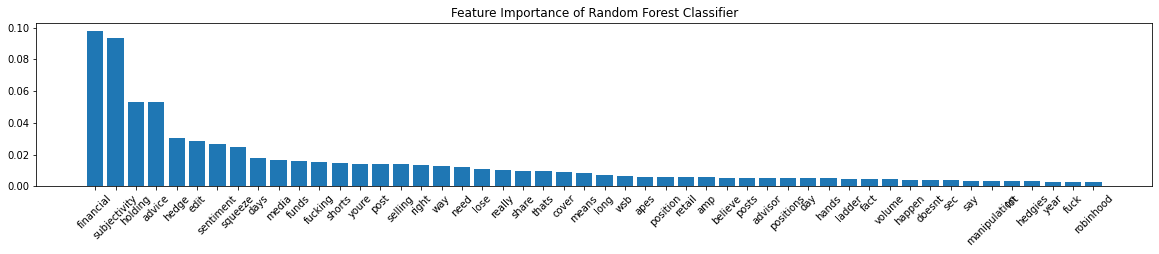

In [ ]:
plt.figure(figsize=(20,3))
plt.bar(top50_rf_features.Feature_Name, top50_rf_features.Importance, data = top50_rf_features)
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.title("Feature Importance of Random Forest Classifier")
plt.show()

* The F1 score of random forest is not as good as logistic regression, maybe further parameter tuning is necessary.
* **If we take a look at the top 50 important features, we can find that sentiment score, subjectivity score, and tokens like "financial", "holding", "hedge", "fund", "squeeze", "media", and "advice" are among the top. This probably reflects that the motivation behind the GameStop event might be some strong sentiment towards hedge funds, and the sense of achievement and "creating history" by the action of short squeezing those hedge funds.**

### XGBoosting Classifier

In [ ]:
xgb_cl = xgb.XGBClassifier(learning_rate=0.1,max_depth=8, n_estimators=200, random_state = 42)
xgb_cl.fit(X_train, y_train)
y_pred = xgb_cl.predict(X_test)

In [ ]:
confusion_matrix(y_test, y_pred)

array([[2835,  165],
       [ 471, 1029]])

In [ ]:
accuracy_score(y_test, y_pred)

0.8586666666666667

In [ ]:
f1_score(y_test, y_pred)

0.7639198218262807

In [ ]:
xgb_fea_imp=pd.DataFrame(list(xgb_cl.get_booster().get_fscore().items()),
                         columns=['feature','importance']).sort_values('importance', ascending=False)

In [ ]:
importances = xgb_cl.feature_importances_

In [ ]:
xgb_feature_imp = pd.DataFrame(list(zip(feature_names, importances)),
               columns =['Feature_Name', 'Importance'])
top50_xgb_features = xgb_feature_imp.sort_values(by=['Importance'], ascending=False).head(50)

In [ ]:
top50_xgb_features

,Feature_Name,Importance
1089,financial,0.013873
2438,sec,0.008711
1349,holding,0.006473
1733,media,0.005683
95,amp,0.005554
3139,youre,0.005490
118,apes,0.004892
1311,hedge,0.004637
3145,subjectivity,0.004549
323,bots,0.004198


In [ ]:
top50_xgb_features.to_csv('./drive/MyDrive/Colab Notebooks/feature_importance_xgb.csv', index = False)

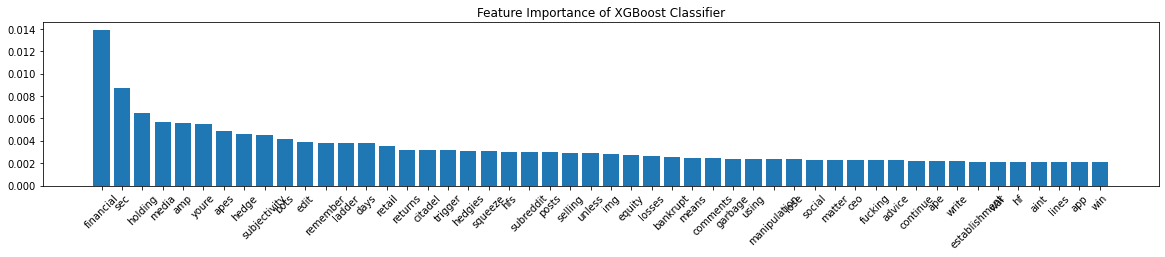

In [ ]:
plt.figure(figsize=(20,3))
plt.bar(top50_xgb_features.Feature_Name, top50_xgb_features.Importance, data = top50_xgb_features)
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.title("Feature Importance of XGBoost Classifier")
plt.show()

* The F1 score of XGBoost Classifier is very good, even without much parameter tuning performed.
* **If we take a look at the top 50 important features, we can find that this set of features is different from the one identified by random forest. The subjectivity score is still among the most important features, but the sentiment score disappears. Tokens like "financial", "sec", "holding", "media", "hedge", "funds", "citadel", "remember", "retail" are among the top. Again, this probably reflects that the motivation behind the GameStop event might be some strong sentiment towards hedge funds like Citadel, and the sense of achievement and "creating history" stimulated by the action of short squeezing those hedge funds by retail investors.**

## Deep Sentence Embeddings

* The TF-IDF matrix is still a very sparse matrix, we can use the Deep Embedding to convert the sparse matrix into a dense one, in order to improve the performance of the model.






In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import keras

In [ ]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)

Let's firstly transform the cleaned text of all the popular submissions (2434 submissions), and the cleaned text of downsampled unpopular submissions (10000 submissions) into dense matrix.

In [ ]:
text_pop = df_minority.cleaned_text.to_list()
emb_pop = model(text_pop)

In [ ]:
# downsample majority class to 10000 submissions
df_unpop_down = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples= 10000,
                                 random_state=42)  # reproducible results
# sentence embedder
text_unpop = df_unpop_down.cleaned_text.to_list()
emb_unpop = model(text_unpop)

In [ ]:
feature_pop = pd.DataFrame(emb_pop.numpy())
feature_unpop = pd.DataFrame(emb_unpop.numpy())

In [ ]:
print(feature_pop.shape, feature_unpop.shape)

(2434, 512) (10000, 512)


**We can find that after the transformation of this embedder, the number of features is 512, which is much less than the 3145 features with the TF-IDF transformation. This matrix is much denser than the TF-IDF matrix. The next step is to add the sentiment score and subjectivity score.**

In [ ]:
textblob_sen_pop = []
textblob_sub_pop = []

for item in text_pop:
    blob = TextBlob(item)
    textblob_sen_pop.append(blob.polarity)
    textblob_sub_pop.append(blob.subjectivity)

In [ ]:
textblob_sen_unpop = []
textblob_sub_unpop = []

for item in text_unpop:
    blob = TextBlob(item)
    textblob_sen_unpop.append(blob.polarity)
    textblob_sub_unpop.append(blob.subjectivity)

In [ ]:
feature_pop['sentiment'] = textblob_sen_pop
feature_pop['subjectivity'] = textblob_sub_pop
feature_unpop['sentiment'] = textblob_sen_unpop
feature_unpop['subjectivity'] = textblob_sub_unpop

In [ ]:
df_features = pd.concat([feature_pop, feature_unpop])
df_features.columns = df_features.columns.astype(str)
labels = pd.concat([df_minority['pop_or_not'], df_unpop_down['pop_or_not']])

**Then we use SMOTE method to upsampling the minority class to be around half of the number of records for the majority class.**

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
### use the SMOTE method to upsampling the minority class
over = SMOTE(sampling_strategy=0.5)
X, y = over.fit_resample(df_features, labels)
### train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [ ]:
y.value_counts()

0    10000
1     5000
Name: pop_or_not, dtype: int64

## Fine tuning for the classifiers
Now we have a denser input for the model, which improves the performance of the models and makes them run faster, we can perform fine tuning for the hyper-pararmeters of Randome Forest classifier and XGBoost Classifier.

#### Random Forest Classifier
* From the simple model fitting with the same set of parameters, we can find that the model performance of random forest classifier with deep embedding matrix (f1 score = 0.68) is much better than the performance with TF-IDF matrix (f1 score = 0.57).
* We will mainly focus on two hyper-parameters here: n_estimators, which is the number of trees; and max_features, which is the number of features to consider when looking for the best split.

In [ ]:
rf_model = RandomForestClassifier(n_estimators = 200, max_depth = 8, max_features = 200)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [ ]:
print(f1_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.6896197327852004
[[1725  275]
 [ 329  671]]


#### Parameter Tuning

In [ ]:
rf_model = RandomForestClassifier()
# define the value lists for the parameters we are interested in
n_estimators = [100, 200]
max_features = [25, 50]
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
# we will use f1 score as the scoring metrics for grid search
grid_search = GridSearchCV(estimator=rf_model, param_grid=grid, n_jobs=-1, cv=5, scoring='f1',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Best: 0.721673 using {'max_features': 50, 'n_estimators': 200}


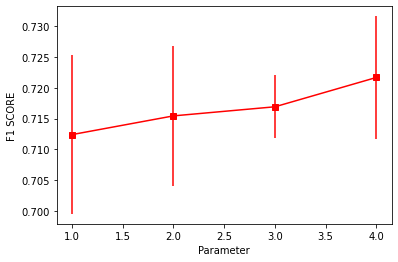

In [ ]:
i = [x for x in range(1,5)]
plt.errorbar(i, means, yerr=stds, marker='s', color='red')

plt.xlabel("Parameter")
plt.ylabel("F1 SCORE")
plt.show()

* **The best parameters are 'max_features' being 50, and 'n_estimators'being 200.**
* The performance of this random forest classifier (F1 score = 0.72) is much better than the one using TF-IDF transformed matrix (F1 score = 0.57).
* We did not use a very wide range of parameter values due to limitation of computational resources. With the parameter list above, it took around 40 minutes to train the grid search model.

#### XGBoost Classifier
* From the simple model fitting with the same set of parameters, we can find that the model performance of XGBoost classifier with deep embedding matrix (f1 score = 0.80) is better than the performance with TF-IDF matrix (f1 score = 0.76).
* For XGBoost classifier, we want to tune the parameters: learning rate, which is the boosting learning rate; and n_estimators, which is the number of boosting rounds.

In [ ]:
xgb_cl = xgb.XGBClassifier(learning_rate=0.1,max_depth=8, n_estimators=200, random_state = 42)
xgb_cl.fit(X_train, y_train)
y_pred = xgb_cl.predict(X_test)

In [ ]:
print(f1_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.7993905535804977
[[1818  182]
 [ 213  787]]


Parameter Tuning

In [ ]:
xgb_model = xgb.XGBClassifier(random_state = 42)
# define the value lists for the parameters we are interested in
n_estimators = [100, 200]
learning_rates = [0.1, 0.3]
max_depth = [8]
# define grid search
grid = dict(n_estimators=n_estimators,learning_rate=learning_rates, max_depth = max_depth)
# we will use f1 score as the scoring metrics for grid search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=grid, n_jobs=-1, cv=5, scoring='f1',error_score=0)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Best: 0.771382 using {'learning_rate': 0.3, 'max_depth': 8, 'n_estimators': 200}


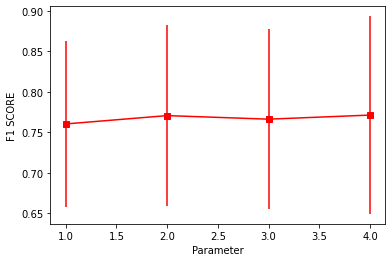

In [ ]:
i = [x for x in range(1,5)]
plt.errorbar(i, means, yerr=stds, marker='s', color='red')

plt.xlabel("Parameter")
plt.ylabel("F1 SCORE")
plt.show()

* **On average, the best parameters are learning_rate = 0.3, max_depth = 8, n_estimators = 200. But we can see from the plot that different combinations of parameters actually have very similar performance. And best performance can be around 0.9**
* The performance of this XGBoost classifier is also better than the one using TF-IDF transformed matrix.

### Limitation
---
* In the modeling process, we disregard the timestamp, and use all the submissions in a certain time period regardless of their timestamp to train the model and test the model. But in the real world, timestamp is important, because trending topics might change over a period of time, and the order of these trending topics is also important.

* We just used the data from Reddit as our data source, and did not acquire more datasets from other social media platforms to cross validate our conclusions from Reddit data analysis. So we cannot make sure that our findings can be generalizable to other social media platforms. 

* We cannot validate whether the proposed monitoring method for predicted popular submission will successfully predict the next huge social media event, since this kind of event is very rare.

### Future Work
---
* We might need to keep the timestamp and treat the dataset as a time series dataset, and properly divide the time periods to generate features and labels. 
* We might need to collect more data from various social media platforms, for example, Twitter, Facebook, ...etc. After analysis of datasets from different sources, we might be able to derive some more generalizable findings and reccomendations.
